In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import sys
import yaml
sys.path.append('.')
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
from ml_collections.config_dict import ConfigDict
from analysis_utils import envs

import jeansgnn_utils as jgnn_ut

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

2024-01-07 18:43:34.348126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 18:43:34.348167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 18:43:34.349628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 18:43:36.553043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Read in the generated dataset
dataset_name = 'wdm/dandy-sun-62'
# dataset_name = 'wdm/hearty-pond-61'
dataset_path = envs.DEFAULT_OUTPUT_DIR / (dataset_name + '.npz')

dataset = np.load(dataset_path)
gen_samples = dataset['samples']
cond = dataset['cond']
mask = dataset['mask']
truth_samples = dataset['truth']

halo_mvir, m_wdm = cond[:, 0], cond[:, 1]

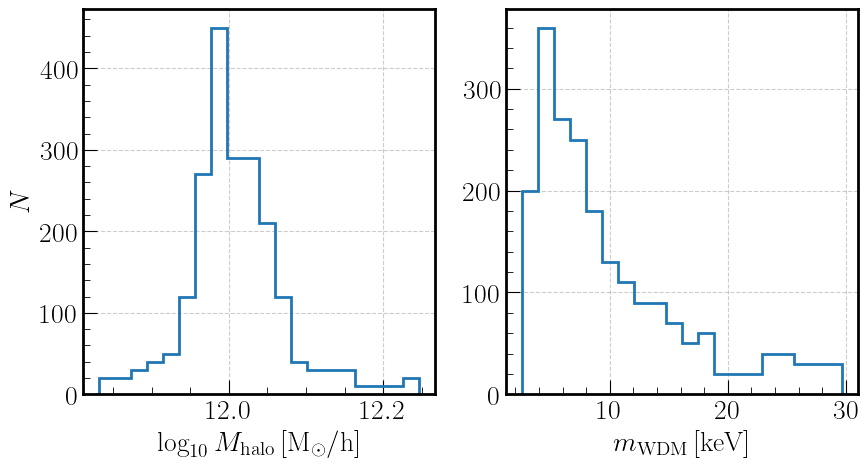

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(halo_mvir, bins=20, histtype='step', lw=2)
axes[1].hist(m_wdm, bins=20, histtype='step', lw=2)
axes[0].set_xlabel(r'$\log_{10} M_\mathrm{halo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$m_\mathrm{WDM} \, [\rm keV]$')
axes[0].set_ylabel(r'$N$')

plt.show()

In [5]:
# divide the data into bins by wdm mass
wdm_mass_bins = [0, 5, 10, 20, 30]
num_wdm_bins = len(wdm_mass_bins) - 1

gen_samples_bins = []
truth_samples_bins = []
mask_bins = []

for i in range(len(wdm_mass_bins) - 1):
    m_min, m_max = wdm_mass_bins[i], wdm_mass_bins[i + 1]
    idx = np.where((m_wdm > m_min) & (m_wdm < m_max))[0]
    
    print(f'Bin {i} [{m_min}, {m_max}] keV: {len(idx)} samples')

    gen_samples_bins.append(gen_samples[idx])
    truth_samples_bins.append(truth_samples[idx])
    mask_bins.append(mask[idx])

Bin 0 [0, 5] keV: 500 samples
Bin 1 [5, 10] keV: 830 samples
Bin 2 [10, 20] keV: 550 samples
Bin 3 [20, 30] keV: 210 samples


In [50]:
m_min = min(gen_samples[..., -1].min(), truth_samples[..., -1].min())
m_max = max(gen_samples[..., -1].max(), truth_samples[..., -1].max())
print(f'Range of masses: [{m_min}, {m_max}]')

Range of masses: [7.811583042144775, 11.962885856628418]


In [71]:
cond[11]

array([12.08536  ,  5.8318458], dtype=float32)

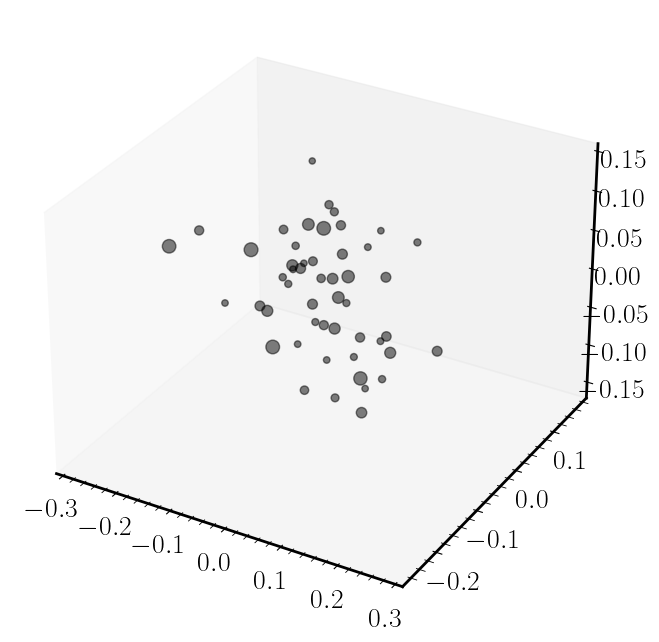

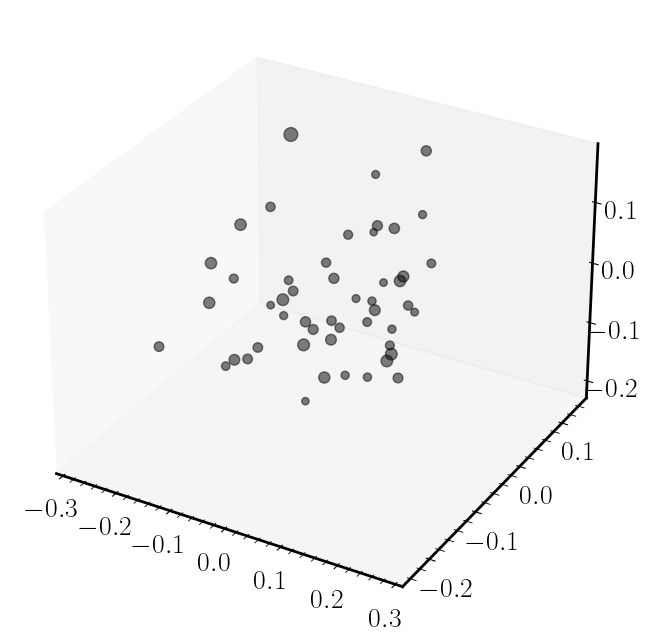

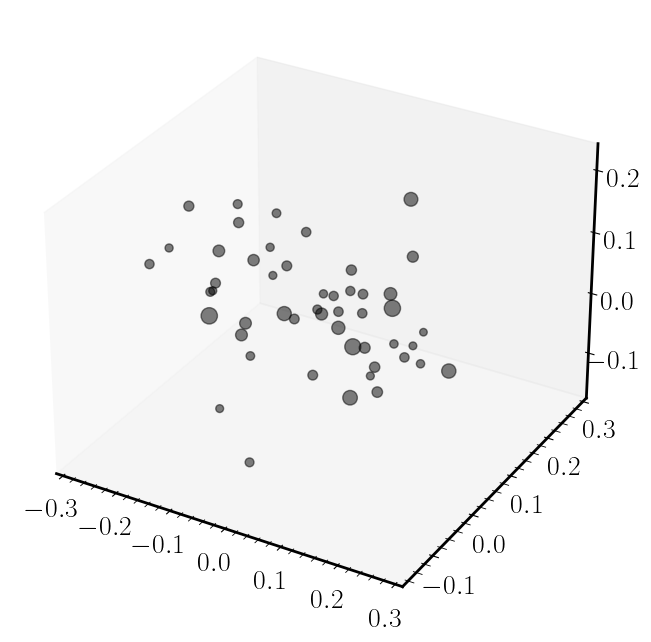

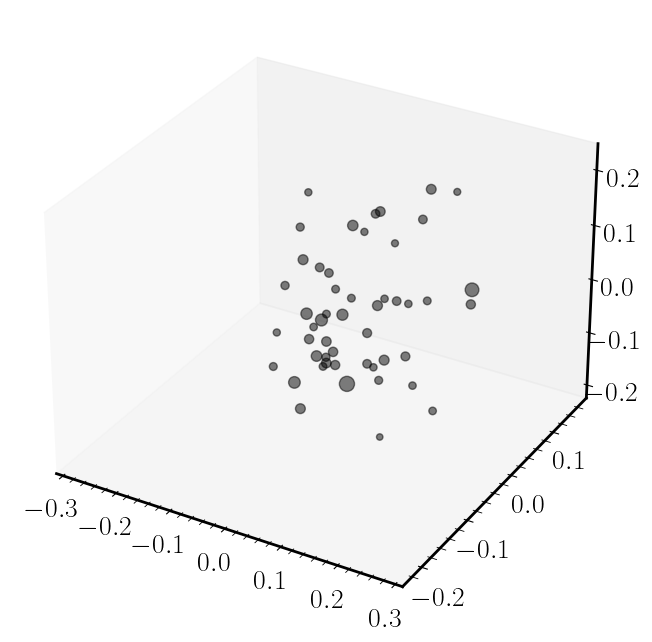

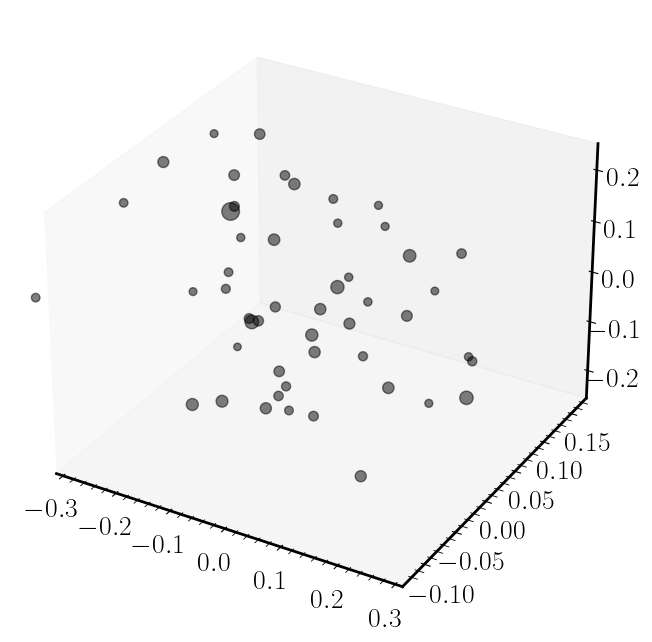

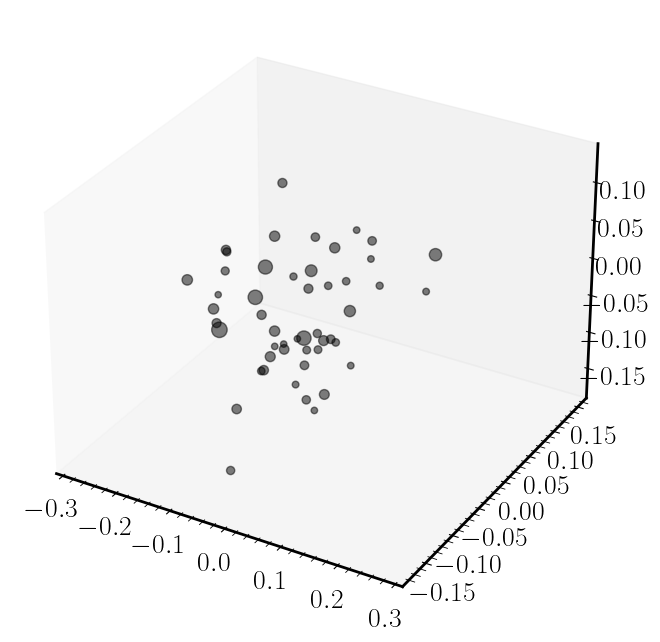

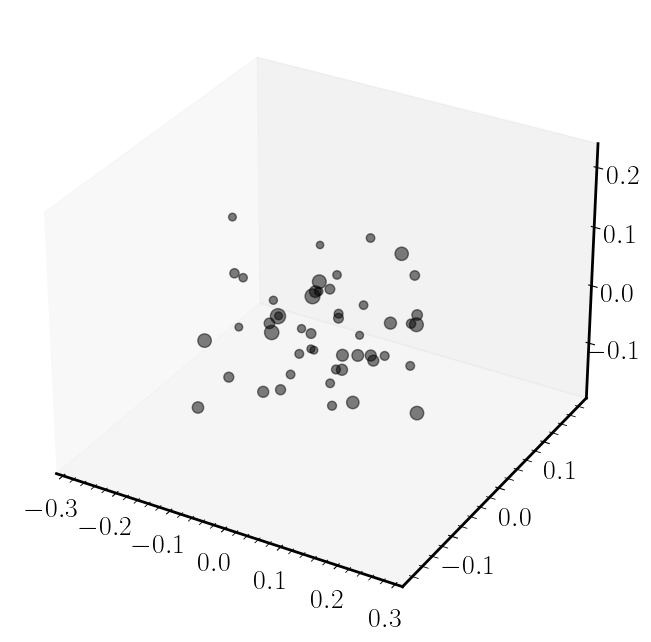

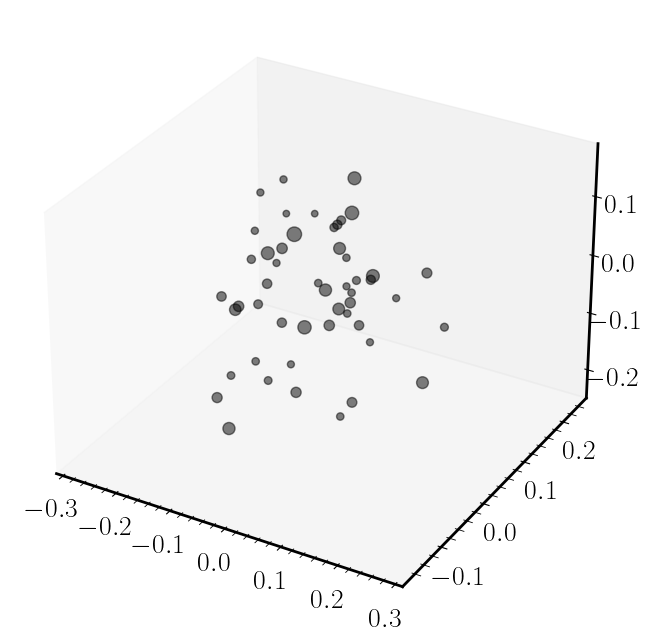

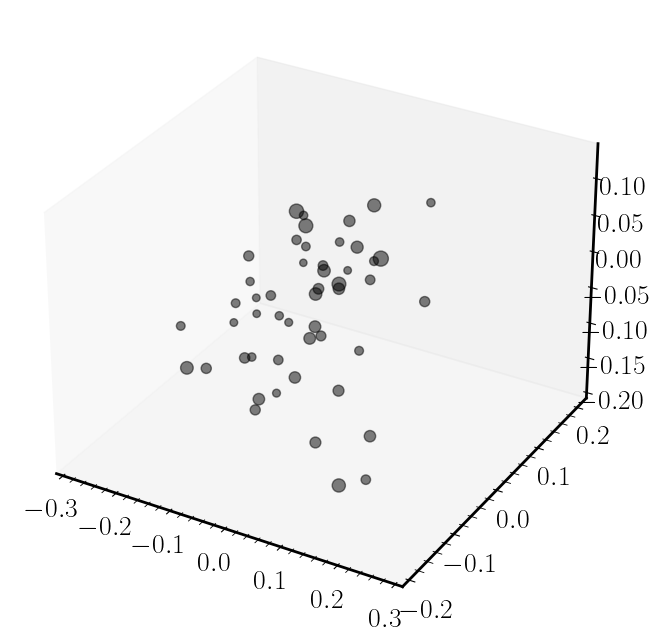

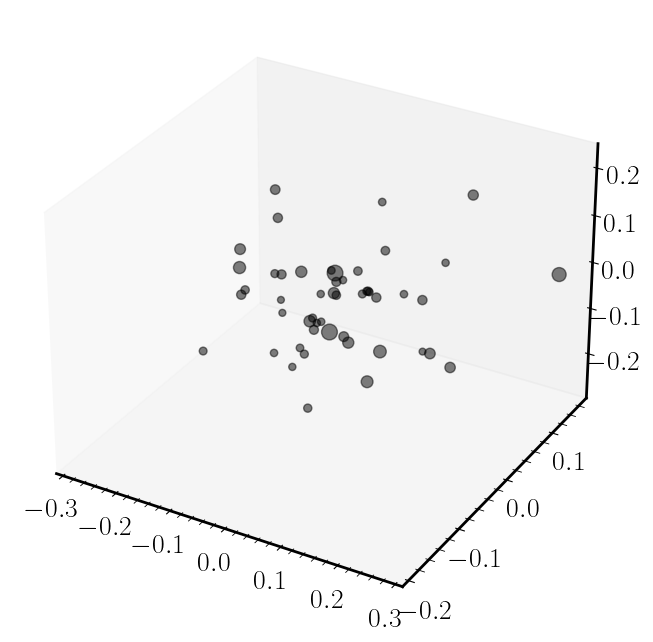

In [76]:
box_size = 0.6
s_min, s_max = 10, 200

# compute the size based on the mass
for i in range(10):
    # Plot the projection
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    plot_samples = gen_samples[i + 10]

    s = s_min + (s_max - s_min) * (plot_samples[:, -1] - m_min) / (m_max - m_min)
    ax.scatter(
        plot_samples[:, 0], plot_samples[:, 1], plot_samples[:, 2],
        alpha=0.5, s=s, c='k')
    ax.set_xlim(-box_size / 2, box_size / 2)

    # turn off grid lines
    ax.grid(False)

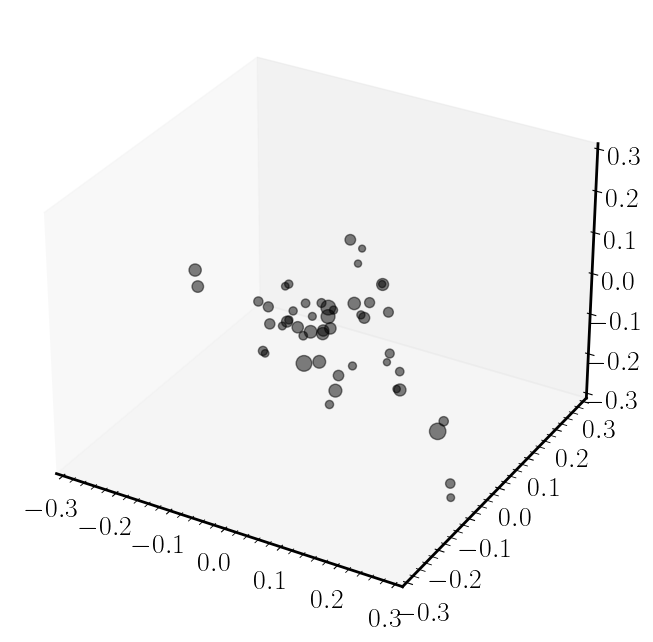

In [78]:
box_size = 0.6
s_min, s_max = 10, 200

# compute the size based on the mass
# Plot the projection
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plot_samples = truth_samples[11]

s = s_min + (s_max - s_min) * (plot_samples[:, -1] - m_min) / (m_max - m_min)
ax.scatter(
    plot_samples[:, 0], plot_samples[:, 1], plot_samples[:, 2],
    alpha=0.5, s=s, c='k')
ax.set_xlim(-box_size / 2, box_size / 2)
ax.set_ylim(-box_size / 2, box_size / 2)
ax.set_zlim(-box_size / 2, box_size / 2)

# turn off grid lines
ax.grid(False)

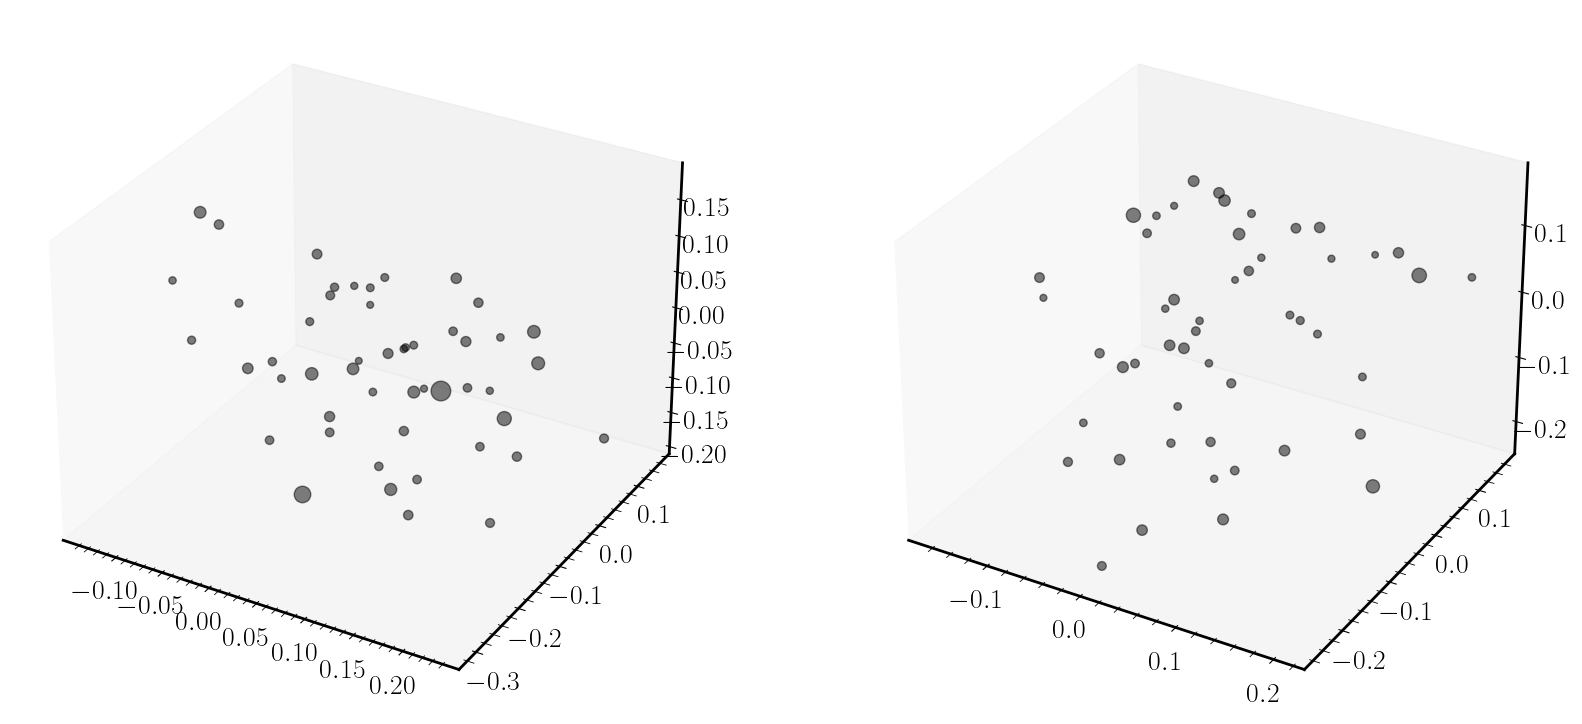

In [49]:
# Plot the projection
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

s_min, s_max = 10, 200

# compute the size based on the mass
plot_samples = gen_samples[63]
s = s_min + (s_max - s_min) * (plot_samples[:, -1] - m_min) / (m_max - m_min)
ax1.scatter(
    plot_samples[:, 0], plot_samples[:, 1], plot_samples[:, 2],
    alpha=0.5, s=s, c='k')

plot_samples = truth_samples[60]
s = s_min + (s_max - s_min) * (plot_samples[:, -1] - m_min) / (m_max - m_min)
ax2.scatter(
    plot_samples[:, 0], plot_samples[:, 1], plot_samples[:, 2],
    alpha=0.5, s=s, c='k')

# turn off grid lines
ax1.grid(False)
ax2.grid(False)